In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train.tsv', 'test.tsv', 'sampleSubmission.csv']


In [15]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Conv1D, GlobalMaxPooling1D, SpatialDropout1D

import tensorflow as tf
session_config = tf.ConfigProto(
    log_device_placement=True,
    inter_op_parallelism_threads=0,
    intra_op_parallelism_threads=0,
    allow_soft_placement=True)
sess = tf.Session(config=session_config)


In [16]:
train = pd.read_csv('../input/train.tsv', sep='\t')

print('train set: {0}'.format(train.shape))
train.head(10)

train set: (156060, 4)


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
5,6,1,of escapades demonstrating the adage that what...,2
6,7,1,of,2
7,8,1,escapades demonstrating the adage that what is...,2
8,9,1,escapades,2
9,10,1,demonstrating the adage that what is good for ...,2


In [17]:
test = pd.read_csv('../input/test.tsv', sep='\t')

print('test set: {0}'.format(train.shape))
test.head(10)

test set: (156060, 4)


,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine
5,156066,8545,intermittently pleasing but
6,156067,8545,intermittently pleasing
7,156068,8545,intermittently
8,156069,8545,pleasing
9,156070,8545,but


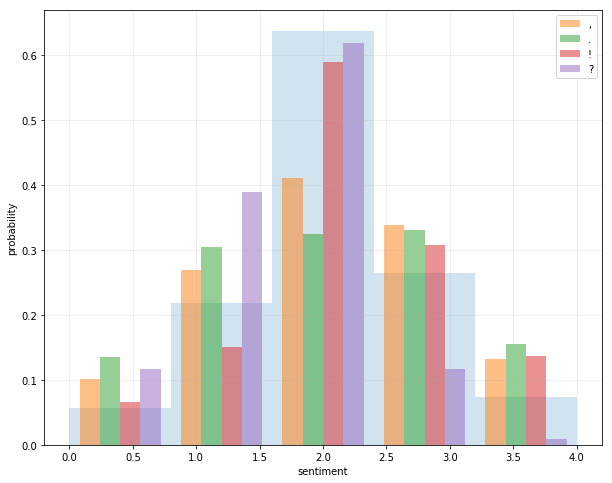

In [18]:
plt.figure(figsize=(10, 8))

plt.hist(train['Sentiment'], 5, alpha=0.2, density=True)

plt.hist(
    [train.loc[train['Phrase'].apply(lambda p: ',' in p), 'Sentiment'],
     train.loc[train['Phrase'].apply(lambda p: '.' in p), 'Sentiment'],
     train.loc[train['Phrase'].apply(lambda p: '!' in p), 'Sentiment'],
     train.loc[train['Phrase'].apply(lambda p: '?' in p), 'Sentiment']],
    5, alpha=0.5, density=True,
    label=[',', '.', '!', '?'])

plt.xlabel('sentiment')
plt.ylabel('probability')
plt.grid(alpha=0.25)
plt.legend(loc='upper right')

max phrase len: 53
use maxlen: 63


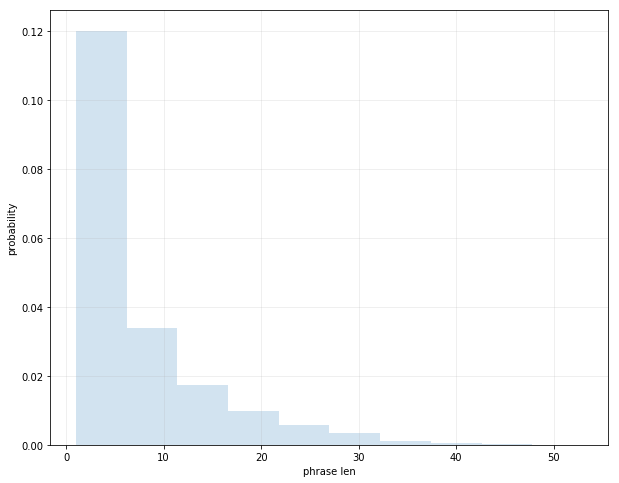

In [19]:
replace_list = {r"i'm": 'i am',
                r"'re": ' are',
                r"let’s": 'let us',
                r"'s":  ' is',
                r"'ve": ' have',
                r"can't": 'can not',
                r"cannot": 'can not',
                r"shan’t": 'shall not',
                r"n't": ' not',
                r"'d": ' would',
                r"'ll": ' will',
                r"'scuse": 'excuse',
                ',': ' ,',
                '.': ' .',
                '!': ' !',
                '?': ' ?',
                '\s+': ' '}

def clean_text(text):
    text = text.lower()
    for s in replace_list:
        text = text.replace(s, replace_list[s])
    text = ' '.join(text.split())
    return text

X_train = train['Phrase'].apply(lambda p: clean_text(p))
phrase_len = X_train.apply(lambda p: len(p.split(' ')))
max_phrase_len = phrase_len.max()+10
print('max phrase len: {0}'.format(max_phrase_len-10)+
      '\nuse maxlen: {0}'.format(max_phrase_len))

plt.figure(figsize=(10, 8))
plt.hist(phrase_len, alpha=0.2, density=True)
plt.xlabel('phrase len')
plt.ylabel('probability')
plt.grid(alpha=0.25)

In [20]:
y_train = train['Sentiment']

tokenizer = Tokenizer(num_words=8192,
                      filters='"#$%&()*+-/:;<=>@[\]^_`{|}~')
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen=max_phrase_len)
y_train = to_categorical(y_train.values)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)
print('X_train size: {0}, '.format(X_train.shape)+
      'y_train size: {0}\n'.format(y_train.shape)+
      'X_val size: {0}, '.format(X_val.shape)+
      'y_val size: {0}'.format(y_val.shape))

X_train size: (140454, 63), y_train size: (140454, 5)
X_val size: (15606, 63), y_val size: (15606, 5)


In [21]:
model_cnn = Sequential()
model_cnn.add(Embedding(8192, 256))
model_cnn.add(SpatialDropout1D(0.5))
model_cnn.add(Conv1D(128, 3, padding='same', activation='relu', strides=1))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dense(256, activation='relu'))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(5, activation='softmax'))
model_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 256)         2097152   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, None, 256)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 128)         98432     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 1285      
Total para

In [22]:
model_cnn.fit(X_train, y_train,
              validation_data=(X_val, y_val),
              epochs=8, batch_size=1024, verbose=1)

Train on 140454 samples, validate on 15606 samples
Epoch 1/8
140454/140454 [==============================] - 9s 64us/step - loss: 1.1773 - acc: 0.5442 - val_loss: 0.9433 - val_acc: 0.6207
Epoch 2/8
140454/140454 [==============================] - 7s 52us/step - loss: 0.8978 - acc: 0.6408 - val_loss: 0.8723 - val_acc: 0.6478
Epoch 3/8
140454/140454 [==============================] - 7s 53us/step - loss: 0.8286 - acc: 0.6660 - val_loss: 0.8452 - val_acc: 0.6576
Epoch 4/8
140454/140454 [==============================] - 7s 53us/step - loss: 0.7864 - acc: 0.6828 - val_loss: 0.8341 - val_acc: 0.6628
Epoch 5/8
140454/140454 [==============================] - 7s 53us/step - loss: 0.7518 - acc: 0.6953 - val_loss: 0.8289 - val_acc: 0.6654
Epoch 6/8
140454/140454 [==============================] - 7s 53us/step - loss: 0.7237 - acc: 0.7065 - val_loss: 0.8292 - val_acc: 0.6663
Epoch 7/8
140454/140454 [==============================] - 7s 53us/step - loss: 0.7009 - acc: 0.7150 - val_loss: 0.8309 -

# LSTM

In [23]:
model_lstm = Sequential()
model_lstm.add(Embedding(8192, 256))
model_lstm.add(SpatialDropout1D(0.3))
model_lstm.add(LSTM(256, dropout=0.3, recurrent_dropout=0.3))
model_lstm.add(Dense(256, activation='relu'))
model_lstm.add(Dropout(0.3))
model_lstm.add(Dense(5, activation='softmax'))
model_lstm.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model_lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 256)         2097152   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, None, 256)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 1285      
Total params: 2,689,541
Trainable params: 2,689,541
Non-trainable params: 0
_________________________________________________________________


In [24]:
# for lstm batch_size should not be too large
model_lstm.fit(X_train, y_train,
               validation_data=(X_val, y_val),
               epochs=8, batch_size=512, verbose=1)

Train on 140454 samples, validate on 15606 samples
Epoch 1/8
140454/140454 [==============================] - 60s 429us/step - loss: 1.0808 - acc: 0.5701 - val_loss: 0.9085 - val_acc: 0.6359
Epoch 2/8
140454/140454 [==============================] - 59s 417us/step - loss: 0.8667 - acc: 0.6525 - val_loss: 0.8606 - val_acc: 0.6513
Epoch 3/8
140454/140454 [==============================] - 59s 417us/step - loss: 0.8134 - acc: 0.6724 - val_loss: 0.8464 - val_acc: 0.6588
Epoch 4/8
140454/140454 [==============================] - 58s 416us/step - loss: 0.7774 - acc: 0.6847 - val_loss: 0.8351 - val_acc: 0.6619
Epoch 5/8
140454/140454 [==============================] - 58s 416us/step - loss: 0.7520 - acc: 0.6942 - val_loss: 0.8365 - val_acc: 0.6654
Epoch 6/8
140454/140454 [==============================] - 59s 417us/step - loss: 0.7284 - acc: 0.7017 - val_loss: 0.8279 - val_acc: 0.6660
Epoch 7/8
140454/140454 [==============================] - 58s 416us/step - loss: 0.7107 - acc: 0.7067 - val_

In [25]:
X_test = test['Phrase'].apply(lambda p: clean_text(p))

print('X_train size: {0}'.format(X_test.apply(lambda p: len(p.split(' '))).max()))

X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen=max_phrase_len)

sub = pd.read_csv('../input/sampleSubmission.csv')
sub.head()

X_train size: 56


,PhraseId,Sentiment
0,156061,2
1,156062,2
2,156063,2
3,156064,2
4,156065,2


In [26]:
y_cnn = model_cnn.predict(X_test)
y_lstm = model_lstm.predict(X_test)

y = y_cnn+y_lstm
y = np.argmax(y, axis=1)
y[:10]

array([3, 3, 2, 2, 2, 2, 3, 2, 3, 2])

In [27]:
sub = pd.read_csv('../input/sampleSubmission.csv')
sub['Sentiment'] = y
sub.head()

,PhraseId,Sentiment
0,156061,3
1,156062,3
2,156063,2
3,156064,2
4,156065,2


In [28]:
sub.to_csv('test_Submission.csv', index=False)